In [2]:
#Pytorch 
import torch
from torch import nn 

#Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#Matplotlib for visualization
import matplotlib.pyplot as plt

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
#setting up datasets 

train_data = datasets.MNIST(
	root="data",
	train=True,
	download=True,
	transform=ToTensor(),
	target_transform=None
)

test_data = datasets.MNIST(
	root="data",
	train=False,
	download=True,
	transform=ToTensor()
)

In [5]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

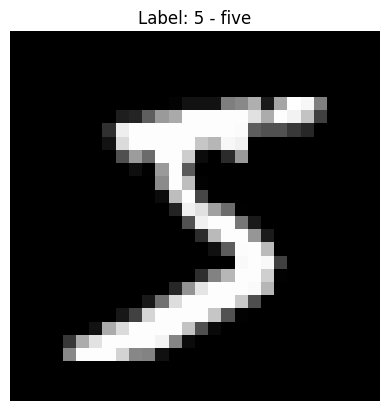

In [7]:
#Get a sample image 
image, label = train_data[0]

#Convert tensor to numpy array for ploting
image_np = image.squeeze().numpy()

#Plot the image 
plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {class_names[label]}")
plt.axis('off')
plt.show()

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


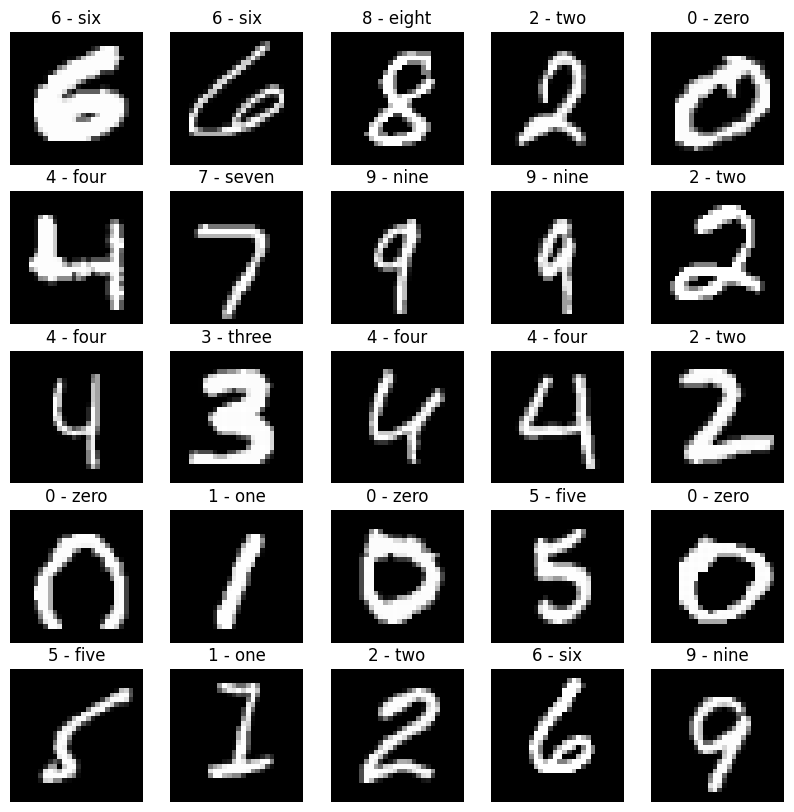

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, colms = 5, 5
for i in range(1, rows * colms + 1):
	random_idx = torch.randint(0, len(train_data), size=[1]).item()
	image, label = train_data[random_idx]
	fig.add_subplot(rows, colms, i)
	plt.imshow(image.squeeze(), cmap="gray")
	plt.title(f"{class_names[label]}")
	print(image.shape)
	plt.axis(False)

In [9]:
from torch.utils.data import DataLoader

#setup the batch size
BATCH_SIZE = 32

#Turn the datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
							  batch_size=BATCH_SIZE,
							  shuffle=True)
test_dataloader = DataLoader(test_data,
							 batch_size=BATCH_SIZE,
							 shuffle=False)

#printing out what been created
print(f"Dataloader: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batch of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batch of {BATCH_SIZE}")


Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x30a167650>, <torch.utils.data.dataloader.DataLoader object at 0x317bbf590>)
Length of train dataloader: 1875 batch of 32
Length of test dataloader: 313 batch of 32


In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
# Functionizing training and testing data step

def train_step(model: torch.nn.Module,
			   data_loader: torch.utils.data.DataLoader,
			   loss_fn: torch.nn.Module,
			   optimizer: torch.optim.Optimizer,
			   accuracy_fn,
			   device: torch.device = device):
	train_loss, train_acc = 0, 0

	model.to(device)

	for batch, (X, y) in enumerate(data_loader):
		print(f"X type: {type(X)}, y type: {type(y), y}")
		#sent data to GPU
		X, y = X.to(device), torch.tensor(y).to(device)
		print(f"X type: {type(X)}, y type: {type(y), y}")
		
		#. 1 forward pass
		y_pred = model(X)

		#. 2 calculate the loss 
		loss = loss_fn(y_pred, y)
		train_loss += loss 
		train_acc += accuracy_fn(y_true = y,
						   		y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
		
		#. 3 Optimizer zero grad
		optimizer.zero_grad()

		#. 4 loss backward
		loss.backward()

		#. 5 Optimizer step
		optimizer.step()

	# Calculate loss and accuracy per epoch and print out what's happening
	train_loss /= len(data_loader)
	train_acc /= len(data_loader)
	print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
			  data_loader: torch.utils.data.DataLoader,
			  loss_fn: torch.nn.Module,
			  accuracy_fn,
			  device: torch.device = device):
	test_loss, test_acc = 0, 0 
	model.to(device)
	model.eval() #put the model in eval mode
	# Turn on inference mode 
	with torch.inference_mode():
		for X, y in data_loader:
			#Sent data to GPU
			X, y = X.to(device), torch.tensor(y).to(device)
			
			#Forward pass 
			test_pred = model(X)
			
			#Calculate loss and accuracy
			test_loss +=loss_fn(test_pred, y)
			test_acc +=accuracy_fn(y_true=y,
						  y_pred=test_pred.argmax(dim=1)) #go from logits -> pred labels 
			
			#Adjust metrics and print out 
			test_loss /=len(data_loader)
			test_acc /=len(data_loader)
			print(f"Test loss: {test_loss:.5f} |Test accuracy: {test_acc:.2f}%\n")

In [12]:
from timeit import default_timer as Timerimer 

def print_train_time(start:float,
					 end:float,
					 device: torch.device = None):
	total_time = end - start
	print(f"Train time on {device}: {total_time:.3f} seconds")
	return total_time
	

## Model_1 building

In [13]:
class MNISTModelV1(nn.Module):
	def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
		super().__init__()
		self.conv_block_1 = nn.Sequential(
			nn.Conv2d(in_channels=input_shape,
				out_channels=hidden_units,
				kernel_size=3,
				stride=1,
				padding=1),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=3,
				stride=1,
				padding=1),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2)
		)
		self.conv_block_2 = nn.Sequential(
			nn.Conv2d(
				in_channels=hidden_units,
			 	out_channels=hidden_units,
			 	kernel_size=3,
			 	stride=1,
			 	padding=1),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=3,
				stride=1,
				padding=1),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2)
			
		)
		self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear(in_features=hidden_units*7*7,
			 out_features=output_shape)
		)

	def forward(self, x: torch.Tensor):
		x = self.conv_block_1(x)
		#print(f"output shape of conv_block_1: {x.shape}")
		x = self.conv_block_2(x)
		#print(f"output shape of conv_block_2: {x.shape}")
		x = self.classifier(x)
		#print(f"output shape of classifier: {x.shape}")

		return x

In [14]:
torch.manual_seed(42)
model_1 = MNISTModelV1(input_shape=1,
					   hidden_units=10,
					   output_shape=10).to(device)

model_1

MNISTModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [15]:
image = torch.rand(size=(1, 28, 28)).to(device)
image.shape

model_1(image.unsqueeze(0))

tensor([[ 0.0372, -0.0748,  0.0573, -0.0396, -0.0098,  0.0194, -0.0003, -0.0114,
          0.0206,  0.0003]], device='mps:0', grad_fn=<LinearBackward0>)

In [16]:
flatten_layer = nn.Flatten()
flatten_layer(image).shape

torch.Size([1, 784])

In [17]:
%time
from tqdm.auto import tqdm

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

epochs = 5 
for epoch in tqdm(range(epochs)):
	train_loss = 0
	for batch, (X, y) in enumerate(train_dataloader):
		model_1.train()

		X, y = X.to(device), y.to(device)

		y_pred = model_1(X)

		loss = loss_fn(y_pred, y)
		train_loss += loss

		optimizer.zero_grad()

		loss.backward()

		optimizer.step()

	train_loss /= len(train_dataloader)

	test_loss_total = 0 

	model_1.eval()

	with torch.inference_mode():
		for  batch, (X_test, y_test) in enumerate(test_dataloader):
			X_test, y_test = X_test.to(device), y_test.to(device)
			
			test_pred = model_1(X_test)
			test_loss = loss_fn(test_pred, y_test)

			test_loss_total += test_loss

		test_loss_total /= len(test_dataloader)
print(f"Epoch: {epochs} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")


CPU times: user 10 μs, sys: 6 μs, total: 16 μs
Wall time: 4.05 μs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 | Loss: 0.046 | Test loss: 0.052


In [18]:
# Functionizing training and testing data step

def train_step(model: torch.nn.Module,
			   data_loader: torch.utils.data.DataLoader,
			   loss_fn: torch.nn.Module,
			   optimizer: torch.optim.Optimizer,
			   accuracy_fn,
			   device: torch.device = device):
	train_loss, train_acc = 0, 0

	

	for batch, (X, y) in enumerate(data_loader):
		#sent data to GPU
		X, y = X.to(device), y.to(device)
		
		#. 1 forward pass
		y_pred = model(X)

		#. 2 calculate the loss 
		loss = loss_fn(y_pred, y)
		train_loss += loss 
		train_acc += accuracy_fn(y_true = y,
						   		y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
		
		#. 3 Optimizer zero grad
		optimizer.zero_grad()

		#. 4 loss backward
		loss.backward()

		#. 5 Optimizer step
		optimizer.step()

	# Calculate loss and accuracy per epoch and print out what's happening
	train_loss /= len(data_loader)
	train_acc /= len(data_loader)
	print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
			  data_loader: torch.utils.data.DataLoader,
			  loss_fn: torch.nn.Module,
			  accuracy_fn,
			  device: torch.device = device):
	test_loss, test_acc = 0, 0 
	model.to(device)
	model.eval() #put the model in eval mode
	# Turn on inference mode 
	with torch.inference_mode():
		for X, y in data_loader:
			#Sent data to GPU
			X, y = X.to(device), y.to(device)
			
			#Forward pass 
			test_pred = model(X)
			
			#Calculate loss and accuracy
			test_loss +=loss_fn(test_pred, y)
			test_acc +=accuracy_fn(y_true=y,
						  y_pred=test_pred.argmax(dim=1)) #go from logits -> pred labels 
			
			#Adjust metrics and print out 
		test_loss /=len(data_loader)
		test_acc /=len(data_loader)
		print(f"Test loss: {test_loss:.5f} |Test accuracy: {test_acc:.2f}%\n")

In [19]:
torch.manual_seed(42)
from helper_functions import accuracy_fn

from timeit import default_timer as timer

train_time_start_model_1 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
	print(f"Epochs {epochs}\n-------")
	train_step(model=model_1,
			data_loader=train_dataloader,
			loss_fn=loss_fn,
			optimizer=optimizer,
			accuracy_fn=accuracy_fn,
			device=device)
	test_step(model=model_1,
		   data_loader=train_dataloader,
		   loss_fn=loss_fn,
		   accuracy_fn=accuracy_fn,
		   device=device)
	
	train_time_end_on_gpu = timer()
	total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
											 end=train_time_end_on_gpu,
											 device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs 3
-------
Train loss: 0.04150 | Train accuracy: 98.69%
Test loss: 0.03396 |Test accuracy: 98.93%

Train time on mps: 9.512 seconds
Epochs 3
-------
Train loss: 0.03784 | Train accuracy: 98.79%
Test loss: 0.02774 |Test accuracy: 99.16%

Train time on mps: 18.834 seconds
Epochs 3
-------
Train loss: 0.03422 | Train accuracy: 98.95%
Test loss: 0.03118 |Test accuracy: 99.06%

Train time on mps: 28.147 seconds


In [20]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [21]:
model_1_results = eval_model(model=model_1,
							 data_loader=test_dataloader,
							 loss_fn=loss_fn,
							 accuracy_fn=accuracy_fn)

model_1_results

{'model_name': 'MNISTModelV1',
 'model_loss': 0.04115549102425575,
 'model_acc': 98.7020766773163}

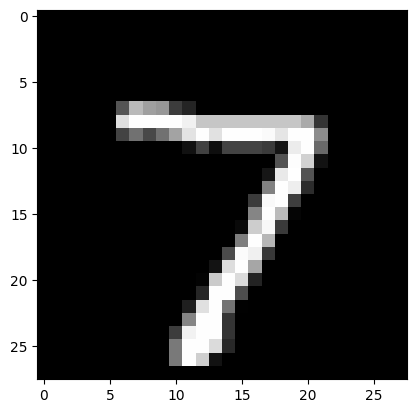

In [27]:
plt.imshow(test_data[0][0].squeeze(), cmap='gray')

In [29]:
model_pred_logits = model_1(test_data[0][0].unsqueeze(dim=0).to(device))
model_pred_probs = torch.softmax(model_pred_logits, dim=1)
model_pred_labels = torch.argmax(model_pred_probs, dim=1)
model_pred_labels

tensor([7], device='mps:0')

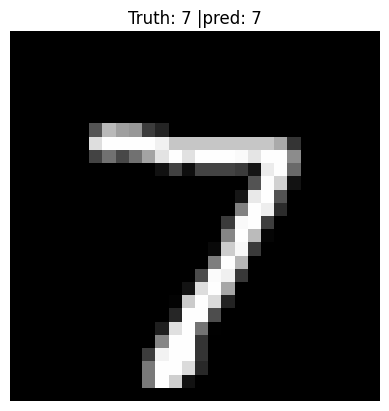

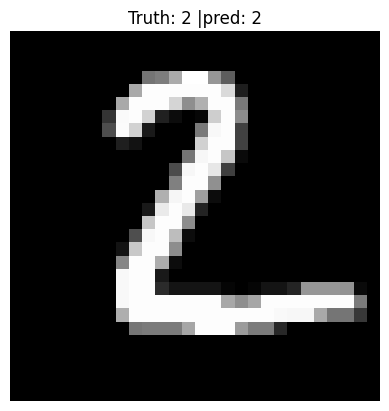

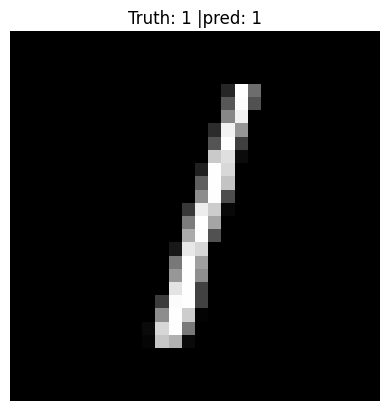

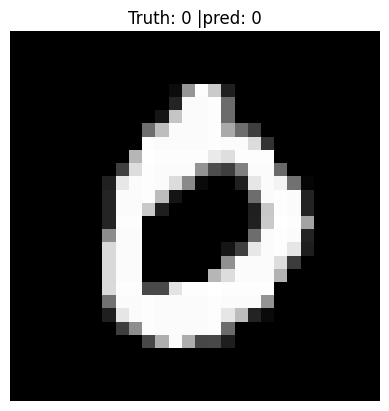

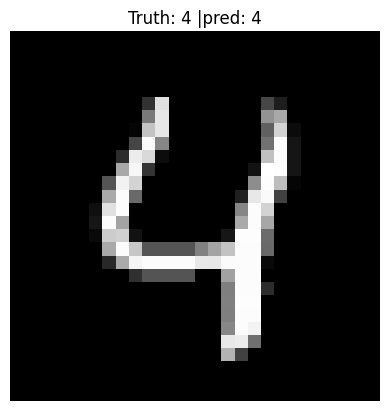

In [31]:
num_to_plot = 5
for i in  range(num_to_plot):
	img = test_data[i][0]
	label = test_data[i][1]

	model_pred_logits = model_1(img.unsqueeze(dim=0).to(device))
	model_pred_probs = torch.softmax(model_pred_logits, dim=1)
	model_pred_labels = torch.argmax(model_pred_probs, dim=1)
	

	plt.figure()
	plt.imshow(img.squeeze(), cmap="gray")
	plt.title(f"Truth: {label} |pred: {model_pred_labels.to(device).item()}")
	plt.axis(False);

In [33]:
from tqdm.auto import tqdm
model_1.eval()
y_preds = []
with torch.inference_mode():
	for batch, (X, y) in tqdm(enumerate(test_dataloader)):
		#data on the right device 
		X, y = X.to(device), y.to(device)

		#forward pass
		y_pred_logits = model_1(X)
		#logits -> preds probs -> preds labels 
		y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
		#Append the labels to the preds list 
		y_preds.append(y_pred_labels)
	y_preds=torch.cat(y_preds).cpu()
len(y_preds)

0it [00:00, ?it/s]

10000

In [35]:
test_data.targets[:10], y_preds[:10]

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

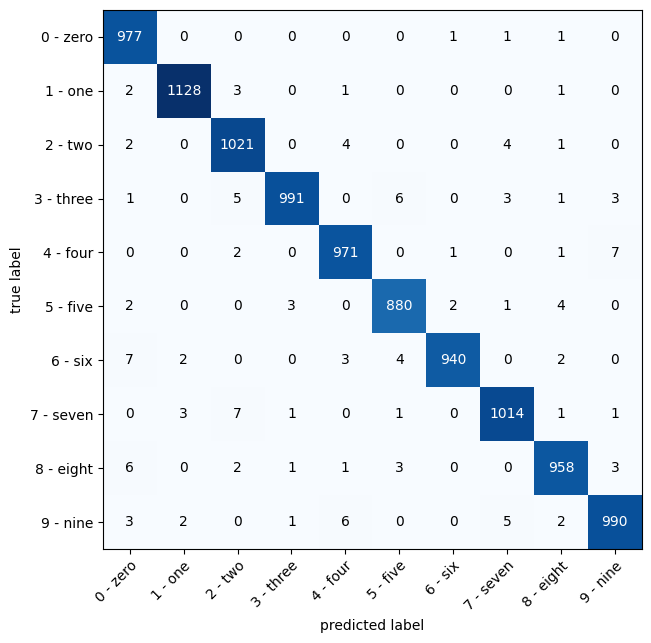

In [36]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#setup confusion matrix 
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds, 
						 target=test_data.targets)

#Plot the confusion matrix 
fix, ax = plot_confusion_matrix(
	conf_mat = confmat_tensor.numpy(),
	class_names = class_names,
	figsize=(10, 7))

In [37]:
random_tensor = torch.rand([1, 3, 64, 64])
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [40]:
conv_layer = nn.Conv2d(in_channels=3,
					   out_channels=64,
					   kernel_size=3,
					   stride=2,
					   padding=1)

a = conv_layer(random_tensor)
a.shape 

torch.Size([1, 64, 32, 32])